In [1]:
!pip install sklearn

In [2]:
# #Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

data = pd.read_csv(r'D:\msc-project\from-github\dissertations-2021-info\rahim_ghani_predict\data\final\features_with_outcome.csv',
                   encoding='utf=8',
                  index_col='org_uuid')
target = 'outcome'

In [3]:
from sklearn.model_selection import train_test_split

y_data = data['outcome']
X_data = data.drop(columns=['outcome'])

X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,stratify=y_data)

In [4]:
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [5]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['outcome'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtest_predictions = alg.predict(dtest[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Training Accuracy : %.4g" % metrics.accuracy_score(dtrain['outcome'].values, dtrain_predictions))
    print ("Test Accuracy : %.4g" % metrics.accuracy_score(dtest['outcome'].values, dtest_predictions))
    print ("Training Precision : %.4g" % metrics.precision_score(dtrain['outcome'].values, dtrain_predictions))
    print ("Test Precision : %.4g" % metrics.precision_score(dtest['outcome'].values, dtest_predictions))
    print ("Training Recall : %.4g" % metrics.recall_score(dtrain['outcome'].values, dtrain_predictions))
    print ("Test Recall : %.4g" % metrics.recall_score(dtest['outcome'].values, dtest_predictions))
    print ("Training f1 : %.4g" % metrics.f1_score(dtrain['outcome'].values, dtrain_predictions))
    print ("Test f1 : %.4g" % metrics.f1_score(dtest['outcome'].values, dtest_predictions))
    print ("Training f2 : %.4g" % metrics.fbeta_score(dtrain['outcome'].values, dtrain_predictions,beta=2.0))
    print ("Test f2 : %.4g" % metrics.fbeta_score(dtest['outcome'].values, dtest_predictions,beta=2))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['outcome'], dtrain_predprob))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(dtest['outcome'], dtest_predprob))
    print ("Training Set Confusion Matrix")
    print (metrics.confusion_matrix(dtrain['outcome'],dtrain_predictions))
    print ("Test Set Confusion Matrix")
    print (metrics.confusion_matrix(dtest['outcome'],dtest_predictions))

In [6]:
#specify parameters taken from autosklearn: Gradient boosting with f1 as target metric
early_stop = 'valid'
l2_regularization = 0.017722562473527163
learning_rate = 0.04226227092427818
loss = 'auto'
max_bins = 255
max_depth = None
max_leaf_nodes = 15
min_sample_leaf = 22
scoring = 'loss'
tol = 1**(-7)
n_iter_no_change = 6

In [7]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]

In [8]:
xgb3 = XGBClassifier(
        learning_rate =learning_rate,
        reg_lambda = l2_regularization,
        reg_alpha = 0.005,
        max_depth=4,
        min_child_weight=2,
        n_estimators=1000,
        gamma=0.13,
        subsample=0.9,
        colsample_bytree=0.87,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=4,
        seed=27
)

modelfit(xgb3, train, test, predictors)

C:\Users\Abdul Rahim Ab Ghani\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Training Accuracy : 0.6943
Test Accuracy : 0.6779
Training Precision : 0.4141
Test Precision : 0.3932
Training Recall : 0.7672
Test Recall : 0.7165
Training f1 : 0.5379
Test f1 : 0.5078
Training f2 : 0.6554
Test f2 : 0.6153
AUC Score (Train): 0.797605
AUC Score (Test): 0.761124
Training Set Confusion Matrix
[[11126  5423]
 [ 1163  3833]]
Test Set Confusion Matrix
[[3676 1841]
 [ 472 1193]]


In [9]:
metrics.log_loss(y_test,xgb3.predict_proba(X_test))

0.6080244074414028

In [10]:
print ("Test Set Confusion Matrix")
print (metrics.confusion_matrix(y_test,xgb3.predict(X_test),normalize='true'))

Test Set Confusion Matrix
[[0.66630415 0.33369585]
 [0.28348348 0.71651652]]


# Features Intrepretation

In [11]:
import shap

In [12]:
shap.initjs()

In [13]:
explainer = shap.TreeExplainer(xgb3)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


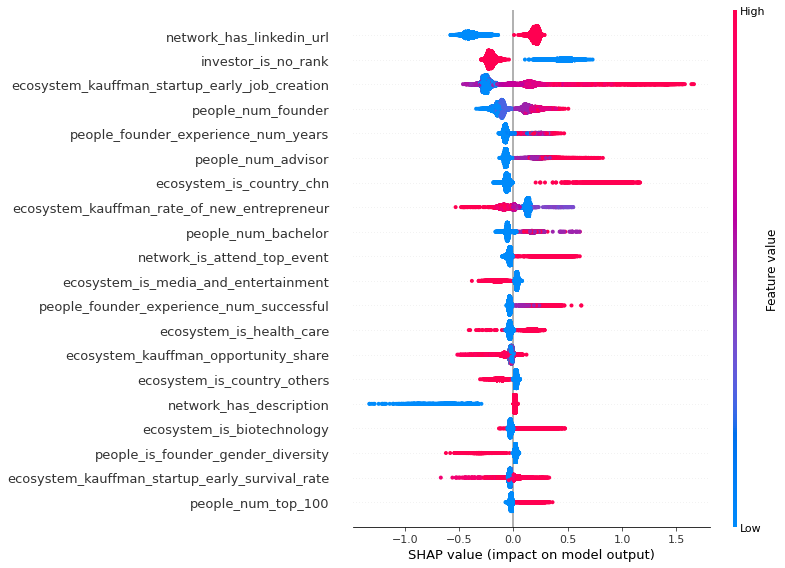

In [14]:
shap.summary_plot(shap_values,max_display=20)

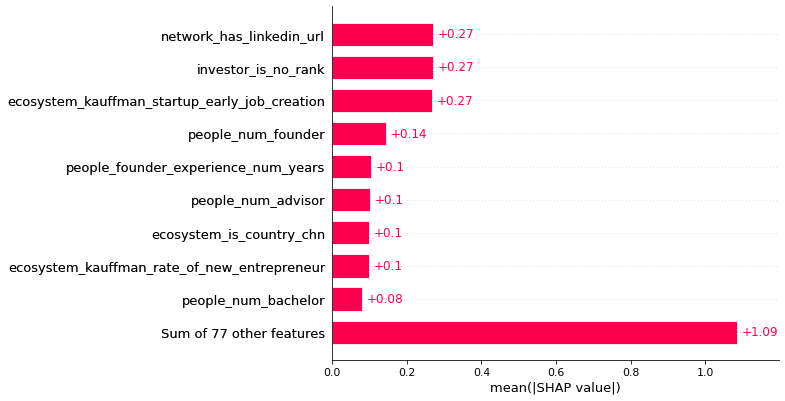

In [15]:
shap.plots.bar(shap_values)

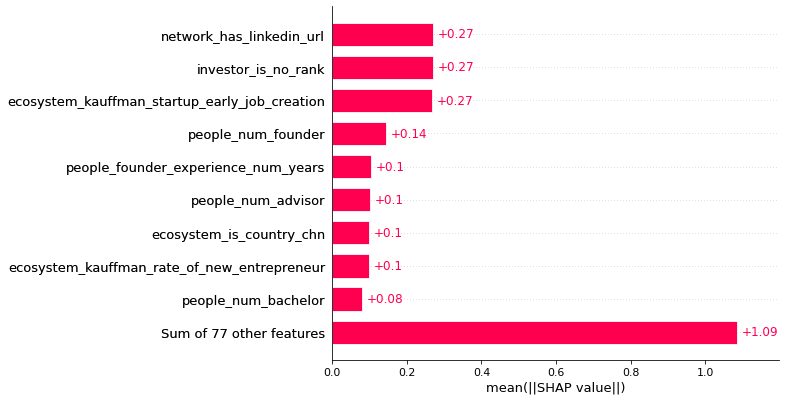

In [16]:
shap.plots.bar(shap_values.abs)

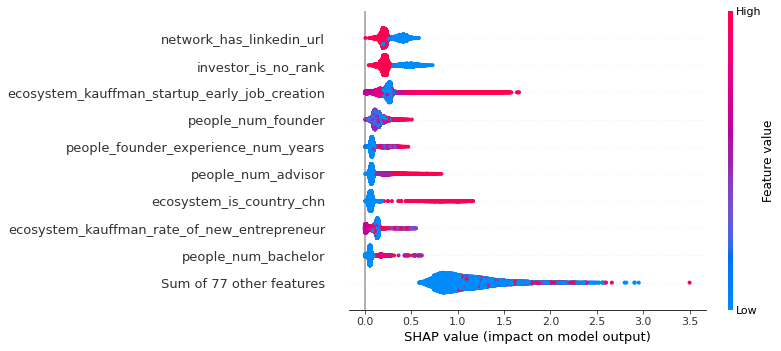

In [17]:
shap.plots.beeswarm(shap_values.abs,)

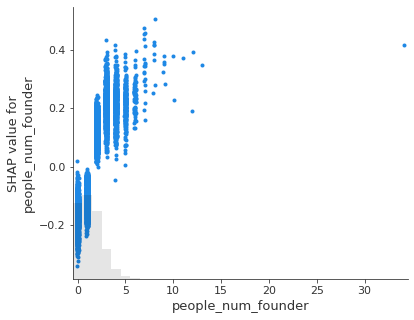

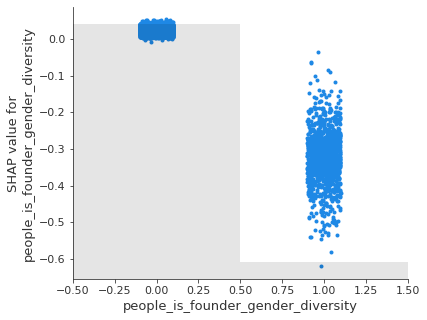

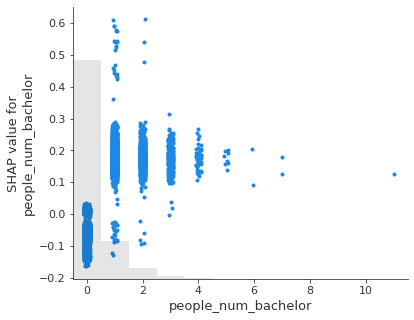

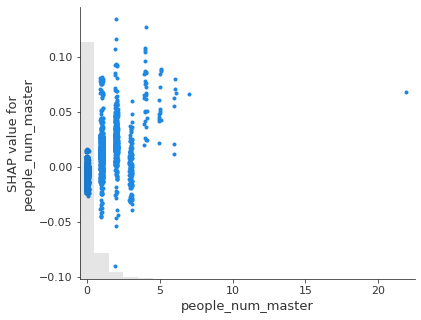

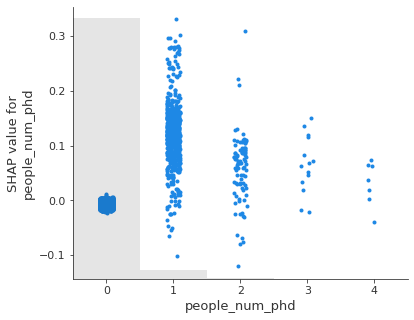

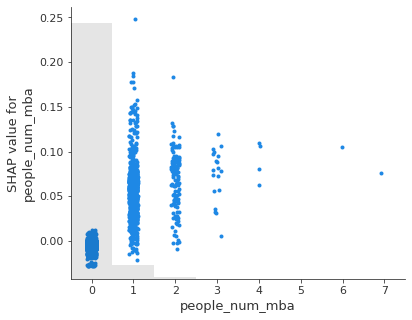

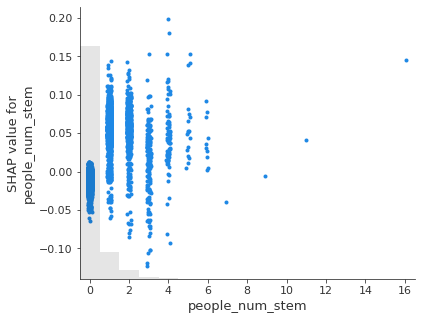

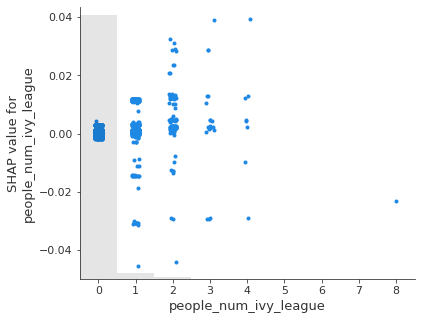

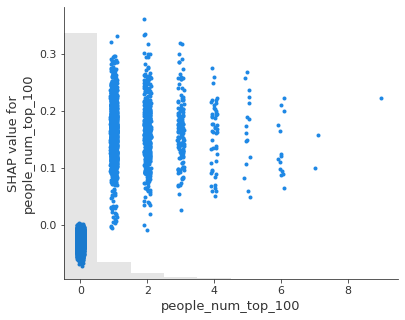

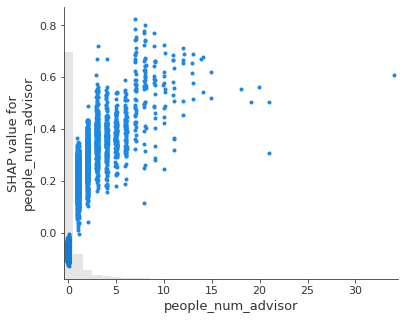

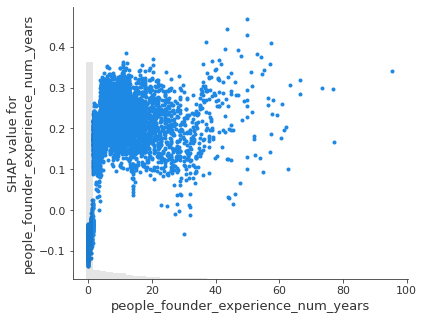

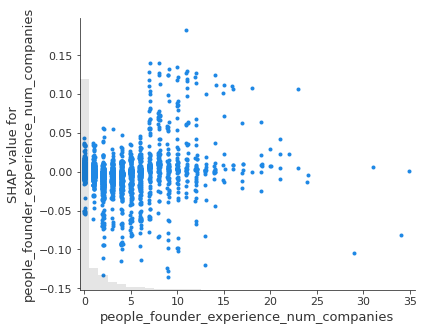

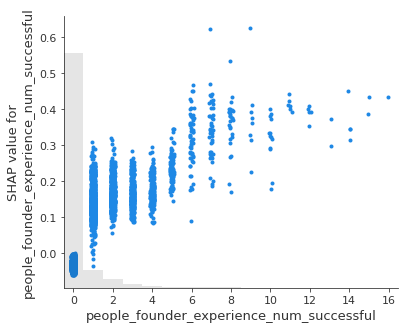

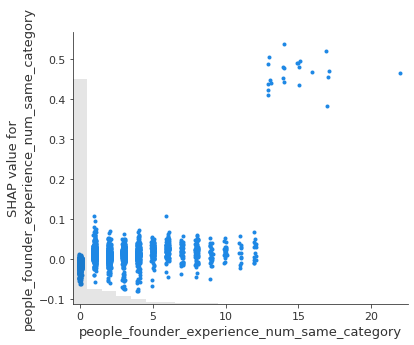

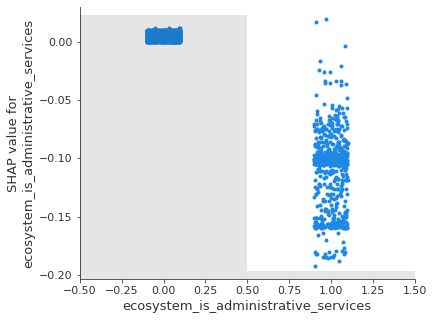

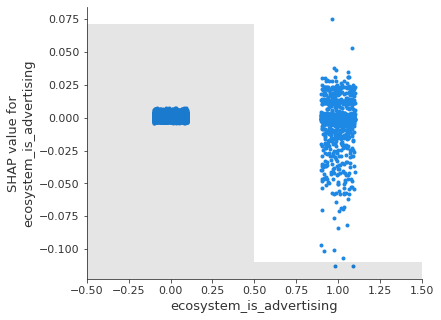

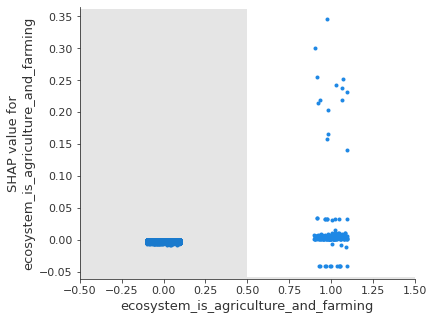

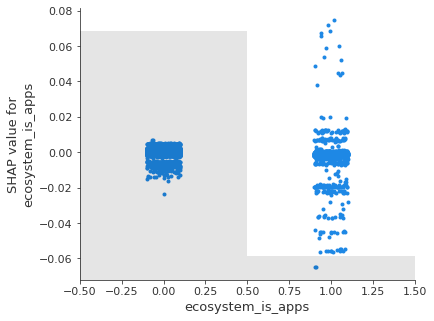

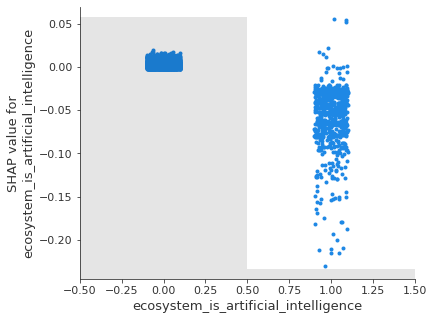

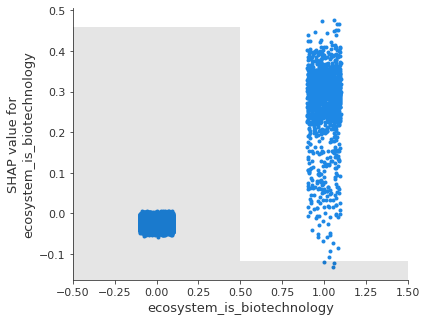

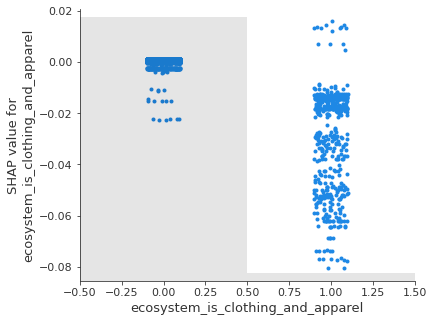

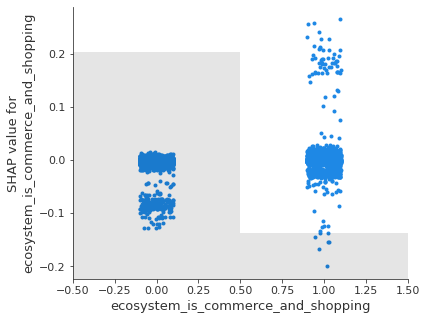

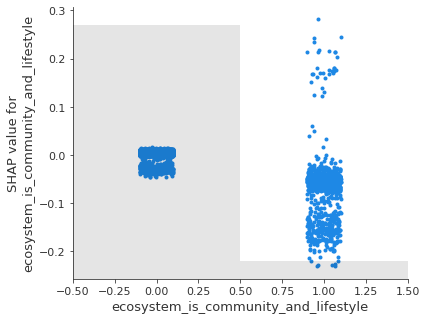

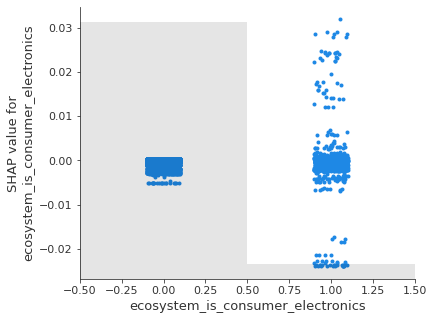

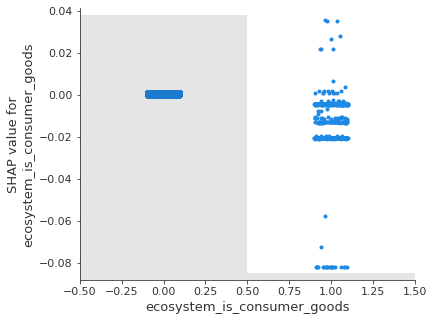

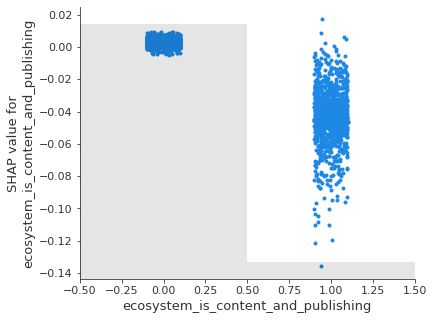

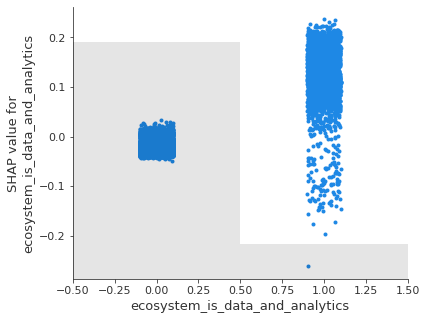

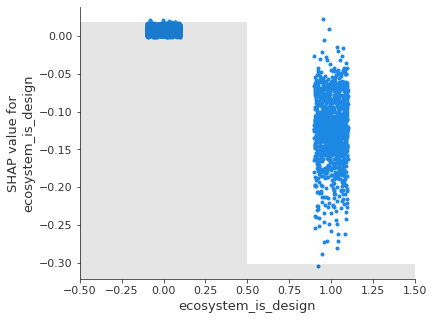

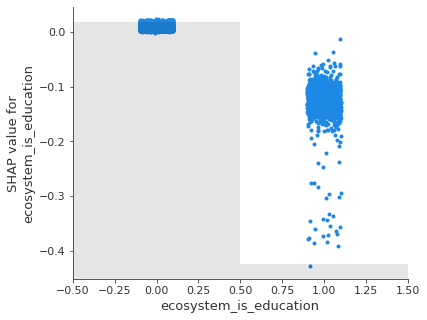

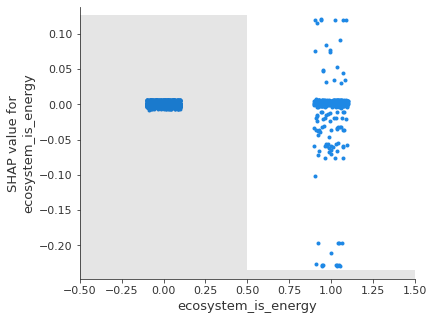

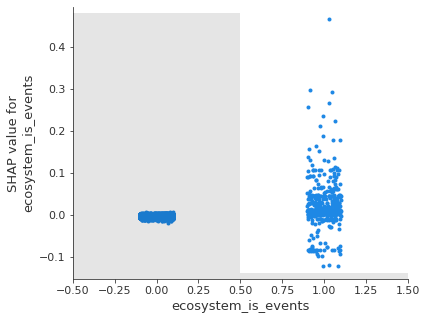

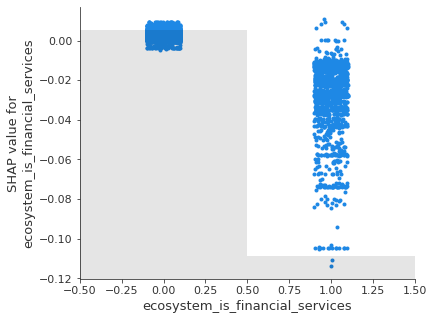

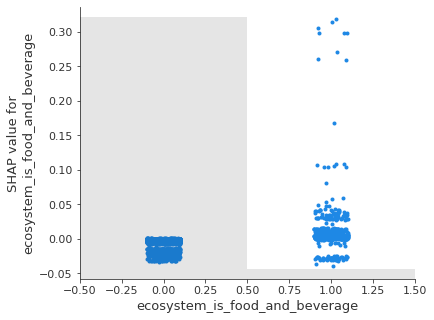

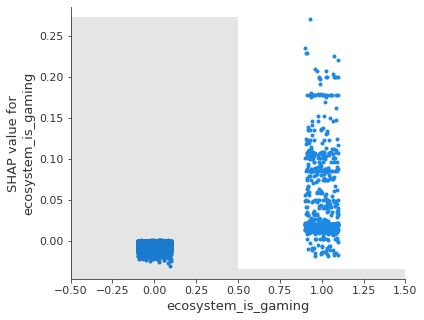

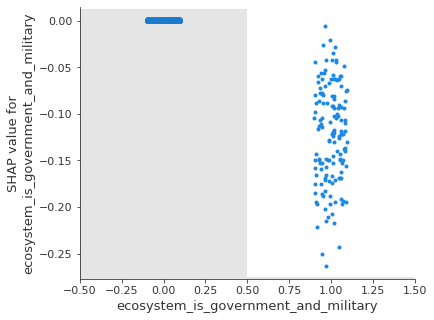

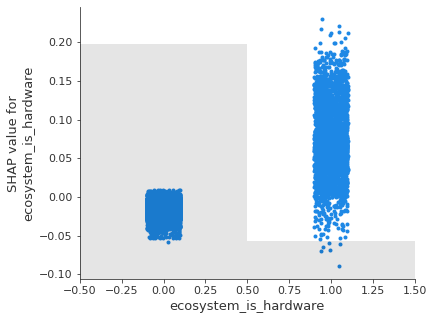

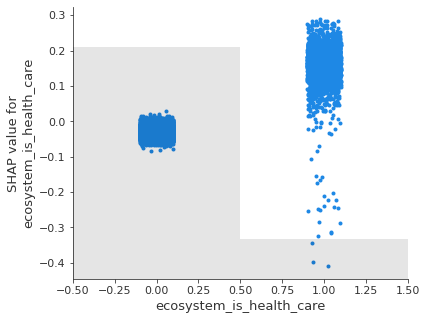

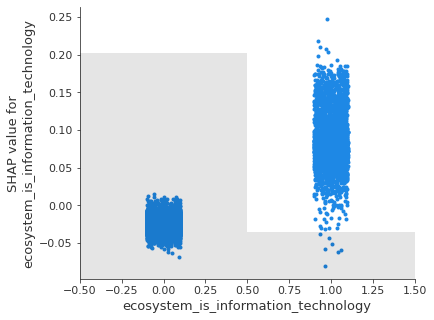

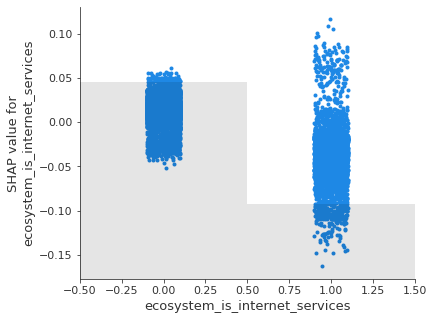

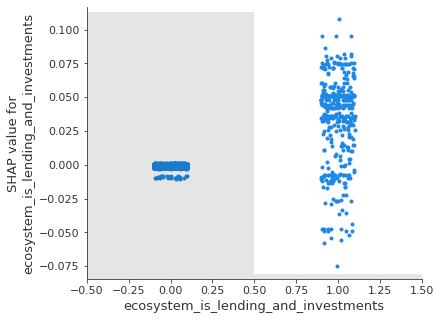

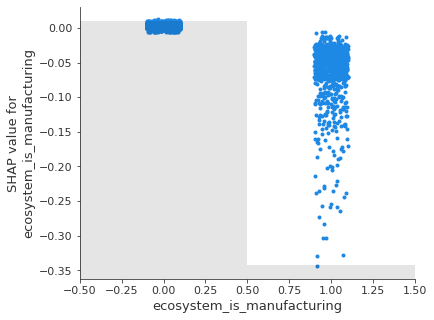

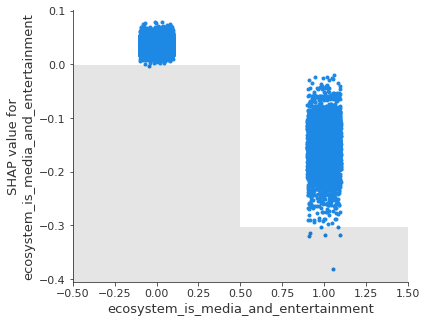

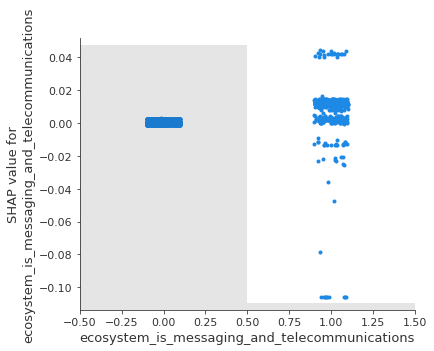

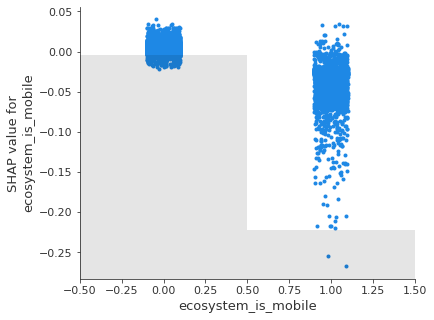

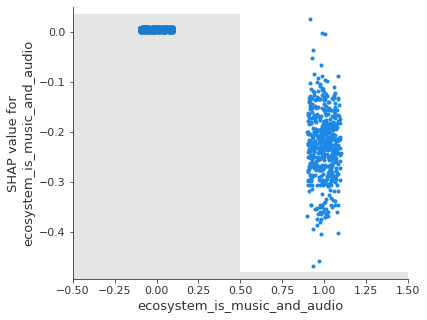

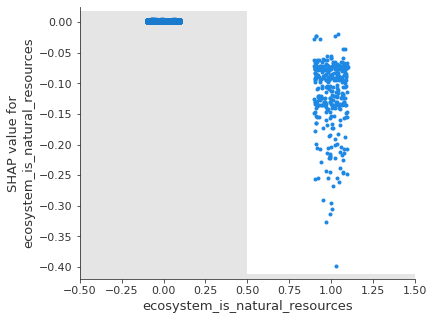

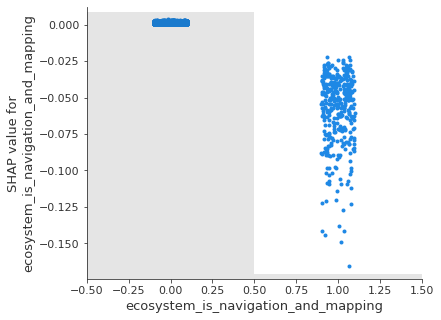

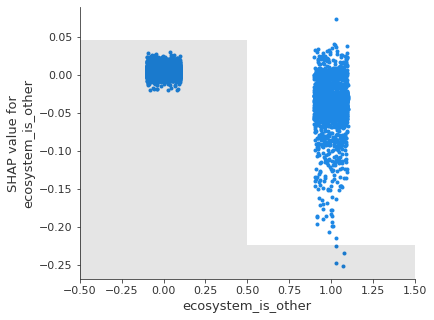

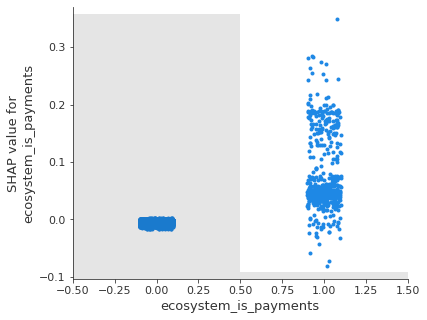

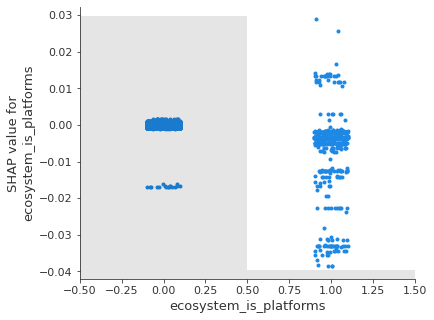

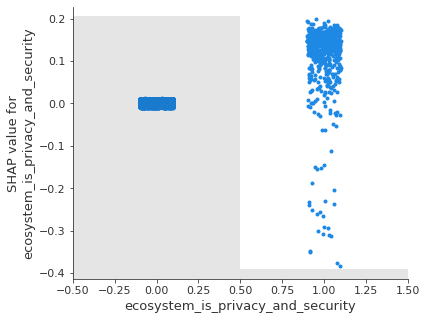

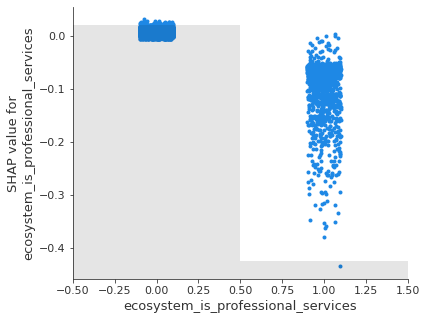

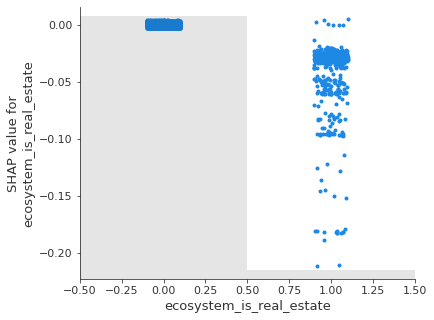

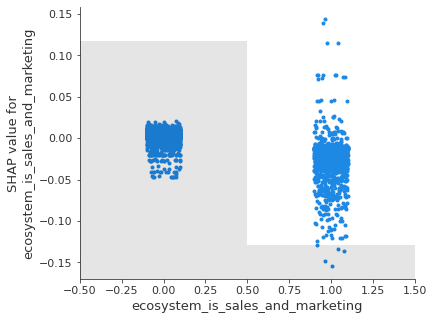

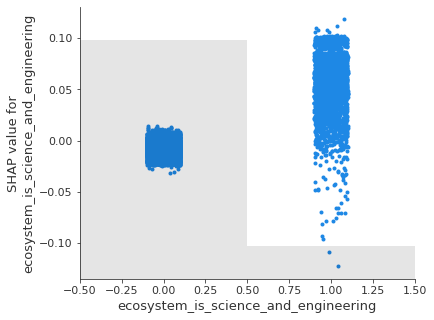

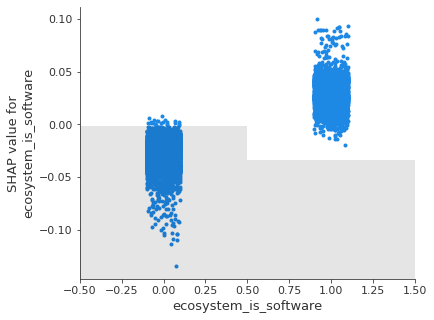

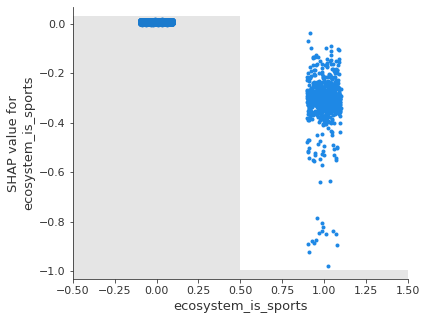

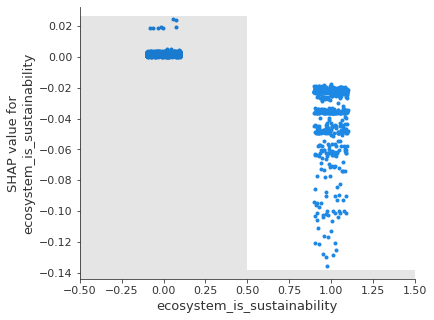

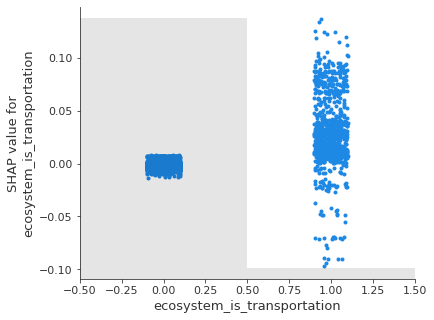

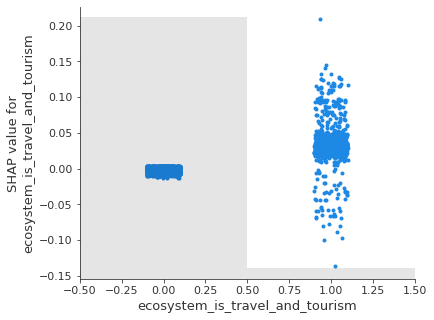

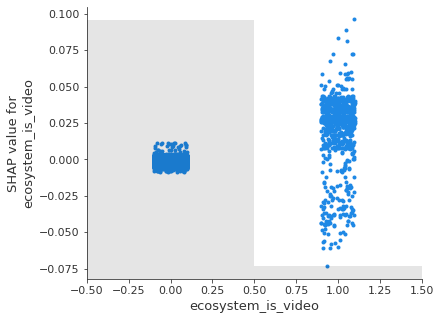

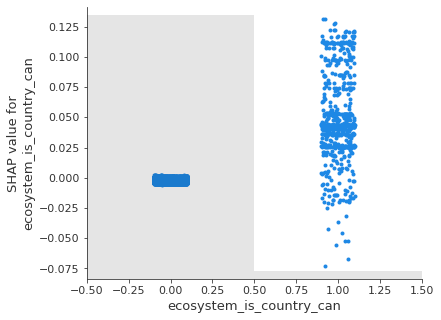

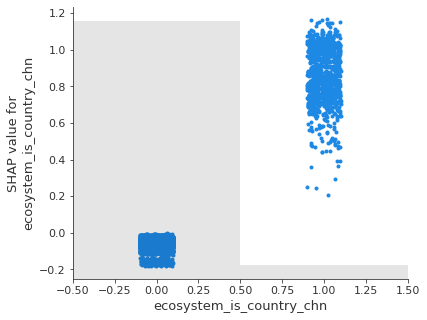

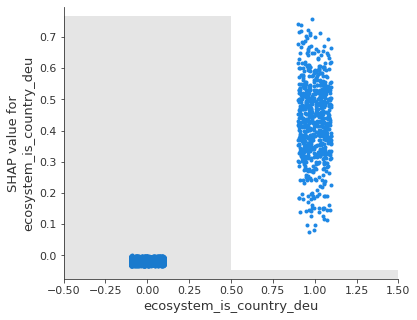

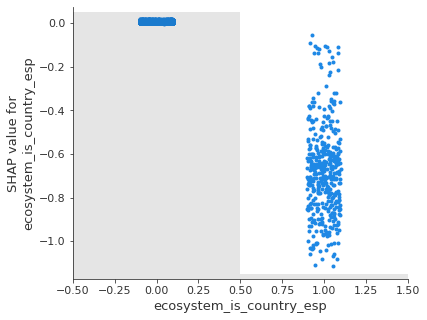

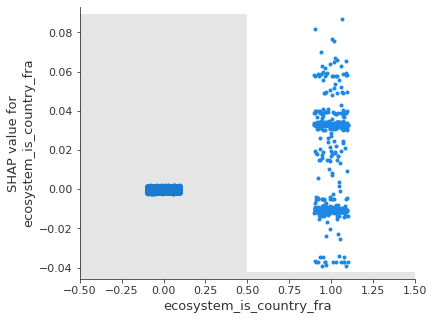

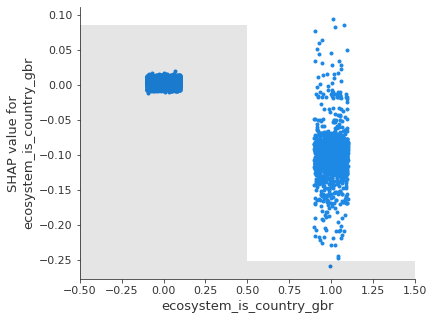

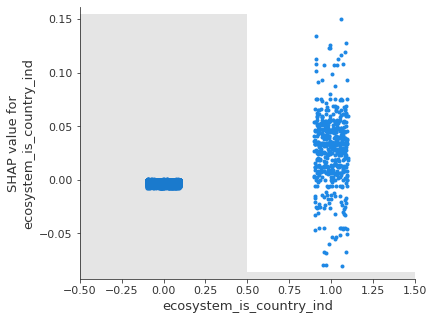

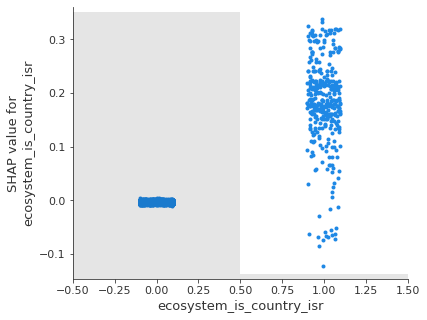

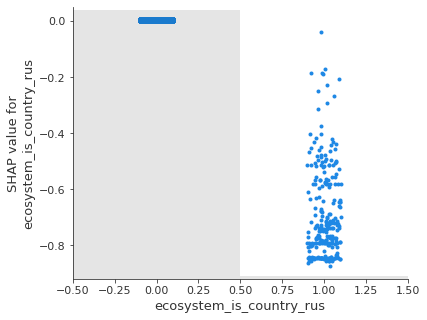

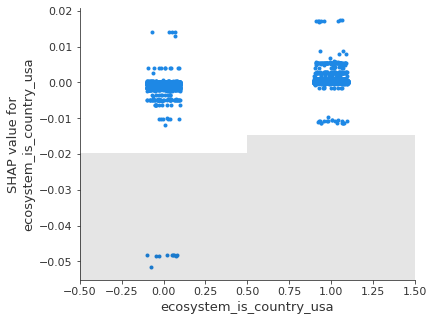

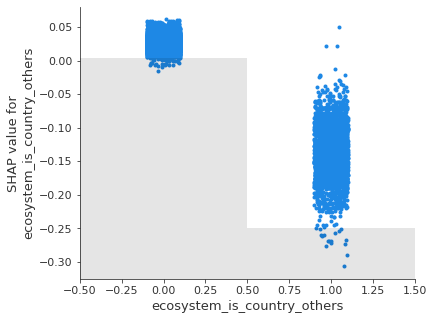

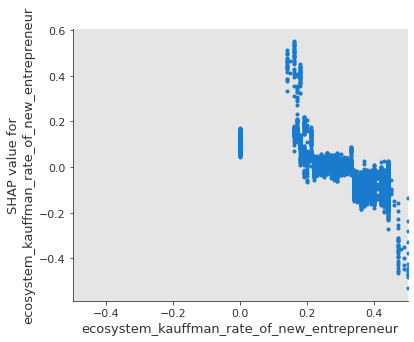

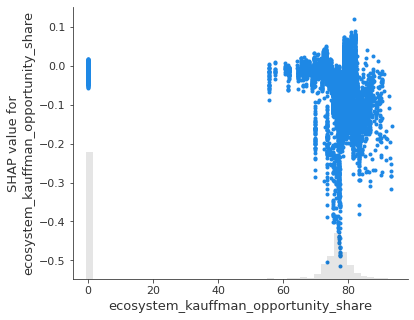

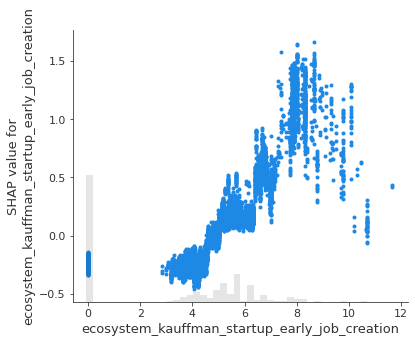

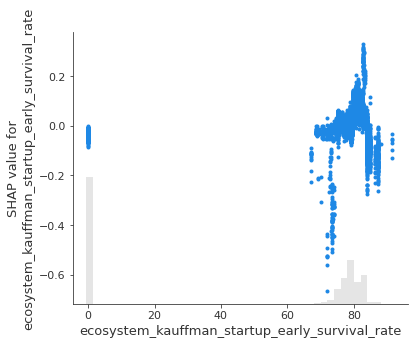

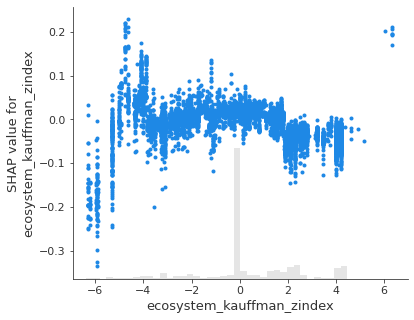

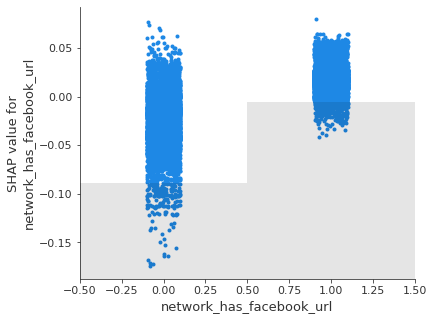

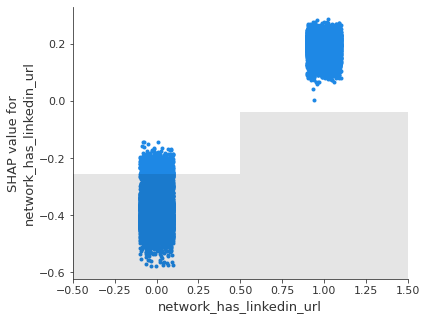

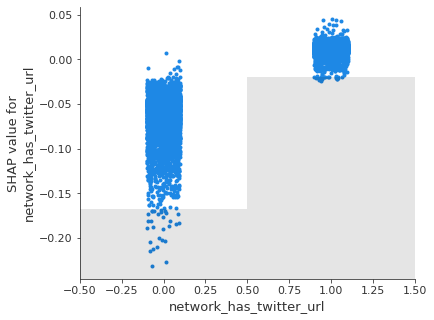

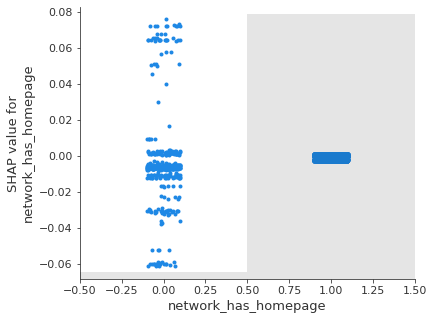

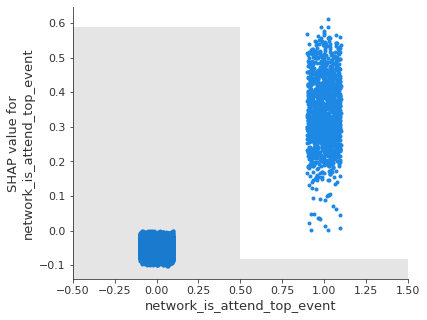

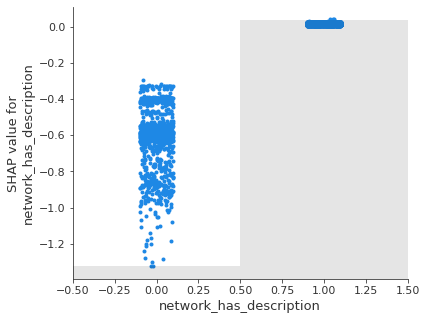

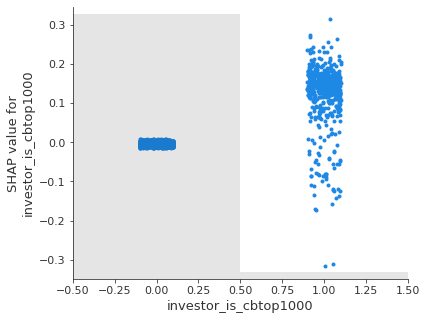

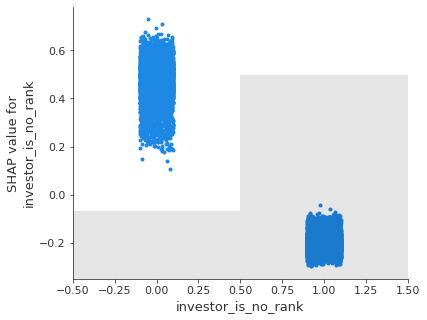

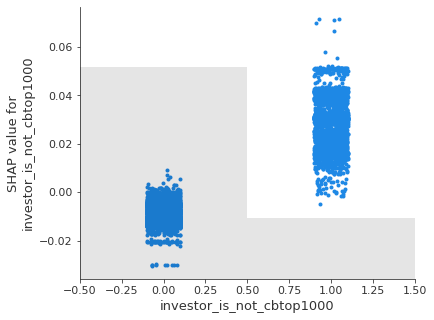

In [18]:
for feature in X_train.columns:
    shap.plots.scatter(shap_values[:,feature])

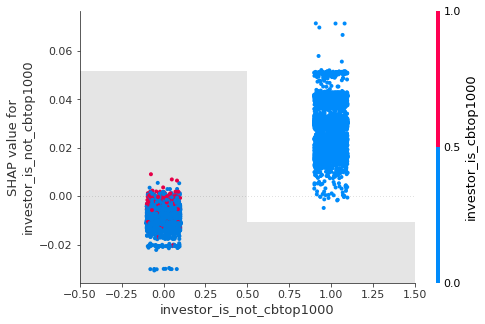

In [19]:
shap.plots.scatter(shap_values[:,'investor_is_not_cbtop1000'],color = (shap_values[:,'investor_is_cbtop1000']))